code by **PAUL ANTONY**

**Importing necessary libraries and dataset from repository.**
Dataset was firstly combined and afterwards cleaned within the team. Following Hypothesis 2 "Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles." will be checked within this Python File.


In [1]:
# Importing the necessary libraries

import re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

#loading our cleaned dataset
df = pd.read_csv('combined_themepark_dataset.csv')
df_original_len = len(df)
print('Original length of dataframe:', df_original_len)

Original length of dataframe: 15443


In [2]:
df.head(1)

,date,profile,message,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,link_posts,picture_posts,video_posts,profile_id,post_id,link,followers
0,12/31/23 9:40 PM,wild adventures theme park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16,2,2,2,"1,09E+12",1.090000e+12,13,NaN,1.0,NaN,84679583132,84679583132_770120045161180,https://www.facebook.com/617429960430190/posts...,66.0


**Main Research Question of the Report:** What strategies can US theme parks employ to enhance audience engagement based on insights from performance analysis on Facebook posts? <br>
**Sub-Research Question for Hypothesis 2:** What impact do different types of posts (link, picture, video) have on the engagement levels of US Theme Park Facebook profiles? 

# Testing Hypothesis 2

* H2a: Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.

* H2b: Posts including pictures and videos generate lower engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.

In [3]:
#check if there are rows without data
df.isnull().sum()

date                         0
profile                      0
message                      0
nr_reactions                 0
nr_comments                  0
nr_shares                    0
comments/post                0
post_interaction_rate        0
engagement                   0
nr_likes                     0
link_posts               14888
picture_posts             3881
video_posts              12964
profile_id                   0
post_id                      0
link                         0
followers                  876
dtype: int64

In [4]:
#check data types
df.dtypes

date                      object
profile                   object
message                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate     object
engagement               float64
nr_likes                   int64
link_posts               float64
picture_posts            float64
video_posts              float64
profile_id                object
post_id                   object
link                      object
followers                float64
dtype: object

In [5]:
#list of column names to drop
columns_to_drop = ['message', 'date', 'profile_id', 'post_id', 'link',]
#remove specified columns
df = df.drop(columns=columns_to_drop)

When examining the data type, it was found that there are a lot of missing values in the columns 'picture_posts' and 'video_posts'. This has to do with the fact that *if it was a picture post*, for example, the value 1 was assigned, on the other hand a NaN value remained. 

As a next step, I will now generate a new feature that combines this information. **So if it is a picture post, the value 1 is assigned. If it is a video post, the value 2 and if the post does not contain an image or video, the value 3.**

In [6]:
#setting conditions for the columns
conditions = [
    ~df['picture_posts'].isna(),  # Not NaN for Picture Posts
    ~df['video_posts'].isna()     # Not NaN for Video-posts
]

#updated values to assign based on the conditions: 1 for picture_posts, 2 for video_posts
values = [1, 2]

#create the new column 'post_type' with an 'other' category for everything else except picture and video posts
df['post_type'] = np.select(conditions, values, default=3)

#display the first few rows of the dataframe to verify the new column
df[['picture_posts', 'video_posts', 'post_type']].head()


,picture_posts,video_posts,post_type
0,1.0,NaN,1
1,NaN,NaN,3
2,NaN,1.0,2
3,1.0,NaN,1
4,NaN,1.0,2


In [7]:
#counting the occurrences of 1, 2, and 3 in the 'post_type' column
post_type_counts = df['post_type'].value_counts()
#displaying the counts
print(post_type_counts)

1    11562
2     2479
3     1402
Name: post_type, dtype: int64


So we can see, that there are `11562` columns containing picture_posts, `2479` columns containing video_posts and `1402` without any of those.

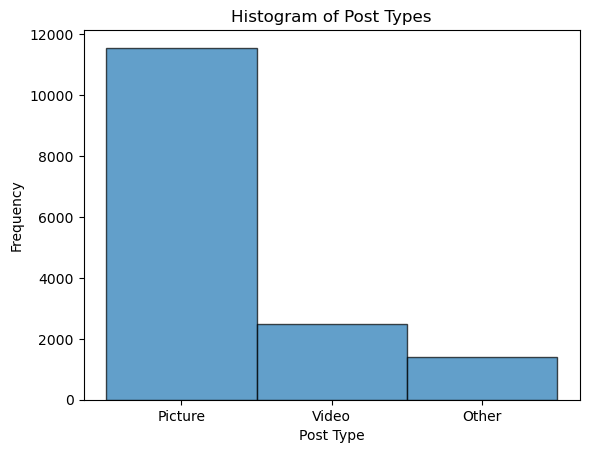

In [8]:
#plotting the histogram for the 'post_type' column
plt.hist(df['post_type'], bins=[0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)

#setting the x-ticks to correspond to the updated post types
plt.xticks(ticks=[1, 2, 3], labels=['Picture', 'Video', 'Other'])

#setting title and labels
plt.title('Histogram of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Frequency')

#displaying the plot
plt.show()

In [9]:
#dropping the specified columns from the DataFrame
df = df.drop(columns=['link_posts', 'picture_posts', 'video_posts'])

In [10]:
#display df in a formatted table
print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════════════╤════════════════╤═══════════════╤═════════════╤═════════════════╤═════════════════════════╤══════════════╤════════════╤═════════════╤═════════════╕
│    │ profile                    │   nr_reactions │   nr_comments │   nr_shares │   comments/post │ post_interaction_rate   │   engagement │   nr_likes │   followers │   post_type │
╞════╪════════════════════════════╪════════════════╪═══════════════╪═════════════╪═════════════════╪═════════════════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│  0 │ wild adventures theme park │             16 │             2 │           2 │               2 │ 1,09E+12                │     1.09e+12 │         13 │          66 │           1 │
├────┼────────────────────────────┼────────────────┼───────────────┼─────────────┼─────────────────┼─────────────────────────┼──────────────┼────────────┼─────────────┼─────────────┤
│  1 │ fun spot america           │             38 │             1 │           2 │   

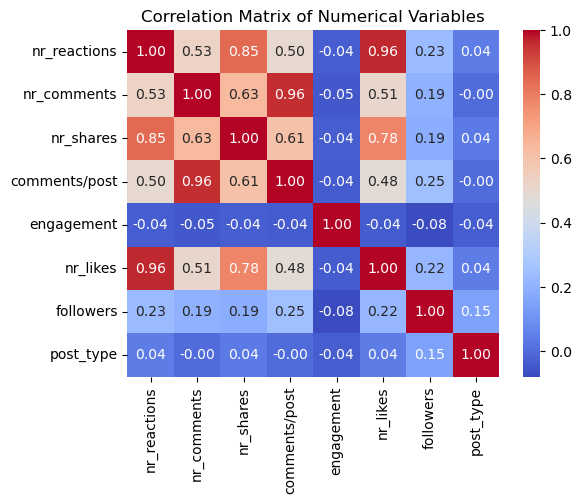

In [11]:
#preperation for correlation analysis on numerical columns, include all the float and int
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
numerical_cols

#plotting the correlation matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

### Check Assumptions for the Two-Sample T-Test and ANOVA:

* **Independence:** Observations across all groups are independent.
* **Normality:**
<br> *T-Test:* Both groups' data should be roughly normal; less critical with larger samples.
<br> *ANOVA:* Residuals must be approximately normal.
* **Homogeneity of Variances:** Variances within each group should be similar. For violations, use Welch’s t-test (for two samples) or Welch ANOVA/Brown-Forsythe (for multiple groups).
* **Scale:** The dependent variable must be continuous (interval or ratio scale).
* **Random Sampling:** Data should come from a random sample of the population.

The **Shapiro-Wilk** test will be performed to *check the normality* of the `'engagement'` data, ensuring it meets the essential assumption for parametric statistical analyses, such as the Two-Sample T-Test and ANOVA. By assessing whether the data are normally distributed, this test helps validate the application of these methods. A p-value greater than 0.05 suggests the data is normally distributed, fulfilling the assumption, **while a lower p-value indicates a deviation from normality, possibly necessitating alternative approaches or data transformation.**

In [12]:
#apply the Shapiro-Wilk test on the engagement column
stat, p = shapiro(df['engagement'].dropna())

#print the test statistic and the p-value
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)

#interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test Statistic: 0.7344919443130493
p-value: 0.0
Sample does not look Gaussian (reject H0)


/Users/carlhumbs/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test shows a p-value of 0.0, indicating a statistically significant departure from normality for the `engagement` column. Consequently, the data **does not follow a normal distribution**, supporting the use of non-parametric statistical tests, such as the **Mann-Whitney U test**, for analyzing differences in engagement scores across different post types.

In [13]:
df.dtypes

profile                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate     object
engagement               float64
nr_likes                   int64
followers                float64
post_type                  int64
dtype: object

### Hypothesis Testing with Mann Whitney U 

Looking at the assumptions check, the decision was made to utilize the **Mann-Whitney U test** for the subsequent steps of our research. This choice was necessitated due to the **failure of our dataset to meet the assumptions requisite** for **both the Analysis of Variance (ANOVA) and the two-sample t-test.** Specifically, the preliminary tests indicated that the data isnt following a normal distribution, which is a critical criterion for the before mentioned statistical methods. The Mann-Whitney U test, being a non-parametric alternative, does not require the data to follow a normal distribution, making it an appropriate method for analyzing the differences between our two independent samples under these conditions.

In [14]:
#separate your data into two groups: one for posts with pictures/videos and one for posts without
group_with_media = df[(df['post_type'] == 1) | (df['post_type'] == 2)]['engagement']
group_without_media = df[df['post_type'] == 3]['engagement']

#perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

#print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

#interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 10256434.0
p-value: 0.004674038950706106
We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.


**Interpretation:** The p-value is `less than 0.05`, which suggests that there is a *statistically significant difference in engagement scores between posts with pictures (post_type 1) and posts without media (post_type 3).* Given that the alternative hypothesis for the test was that **posts with media have higher engagement, this result suggests that picture posts are associated with higher engagement than posts without media.**

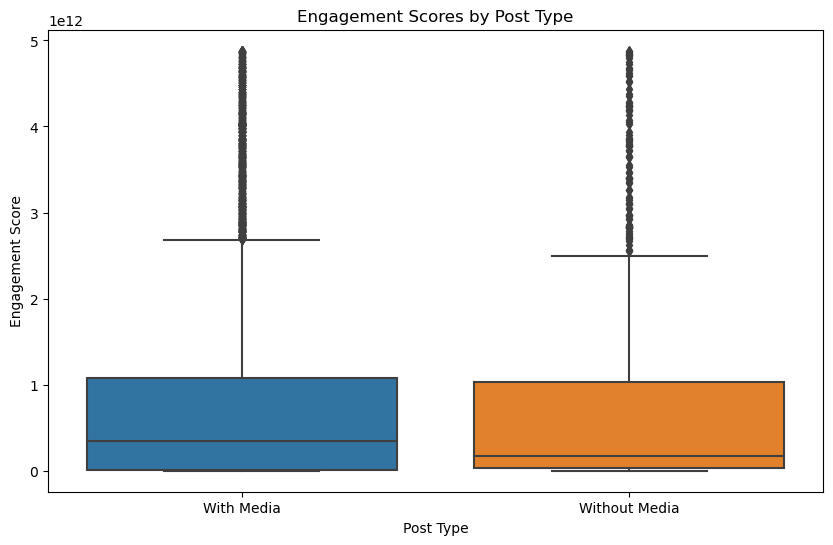

In [15]:
#where 1 indicates posts with media and 3 indicates posts without media.

#create a new column for ease of plotting
df['Group'] = df['post_type'].apply(lambda x: 'With Media' if x == 1 else 'Without Media' if x == 3 else 'Other')

#create a boxplot to visualize the engagement scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='engagement', data=df[df['Group'].isin(['With Media', 'Without Media'])])
plt.title('Engagement Scores by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


The box plot displays the engagement scores for *two different types of social media posts:* those **with media** and those **without**. **The 'With Media' category shows a wider range of scores**, with a substantially **lower median compared to the 'Without Media' category**, which has a higher median engagement score and a much narrower interquartile range (IQR). The presence of outliers, especially in the 'Without Media' category, suggests some posts achieve extraordinarily high engagement. Despite the lower median in the 'With Media' category, the Mann-Whitney U test results indicate a statistically significant difference between the two types of posts, with posts including media (post_type 1) associated with higher overall engagement compared to posts lacking media (post_type 3). This is counterintuitive to the box plot, where the median score appears lower for the 'With Media' category, suggesting that the influence of outliers or the distribution shape might be factors contributing to this significant result.

In [16]:
#separate your data into two groups: one for posts with pictures/videos and one for posts without
group_with_media = df[(df['post_type'] == 2) | (df['post_type'] == 2)]['engagement']
group_without_media = df[df['post_type'] == 3]['engagement']

#perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

#print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

#interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 1763285.0
p-value: 0.22343316978941552
We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.


**Interpretation:** The p-value is `greater than 0.05`, which suggests that *there is no statistically significant difference in engagement scores between posts with videos (post_type 2) and posts without media (post_type 3).* This means that, based on your sample, **video posts do not show a significant difference in engagement compared to other types of posts.**

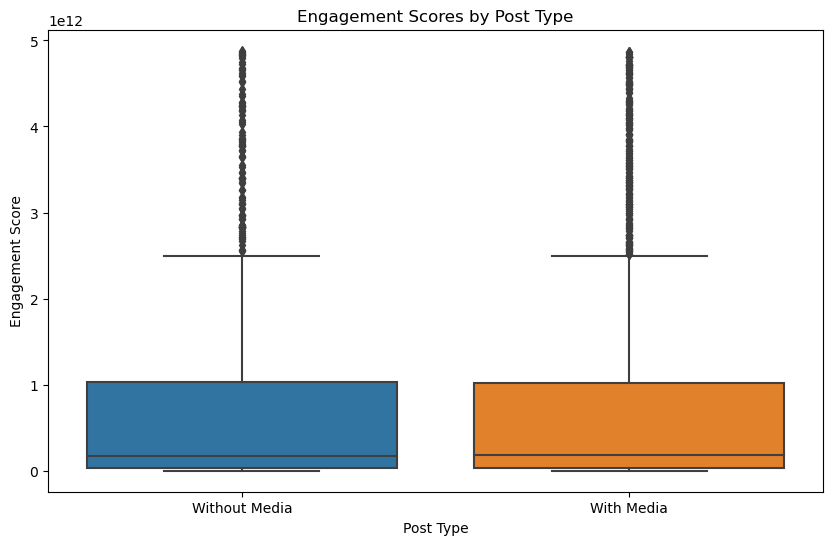

In [17]:

#map the post types to more descriptive labels
df['Post Type Label'] = df['post_type'].map({2: 'With Media', 3: 'Without Media'})

#filter out rows where 'post_type' is not 2 or 3, if there are any
plot_data = df[df['post_type'].isin([2, 3])]

#create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Post Type Label', y='engagement', data=plot_data)
plt.title('Engagement Scores by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


In [18]:
########################################################
### nächsten markdown anpassen auf deine änderungen ###
########################################################

## **Exporting the dataframe for further analysis**
To work on our multilevel analysis, we will now create a new csv version of the dataframe, which includes the XX features that have been created in this notebook (XX, XX).

In [19]:
df.head(5)

,profile,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,followers,post_type,Group,Post Type Label
0,wild adventures theme park,16,2,2,2,"1,09E+12",1.090000e+12,13,66.0,1,With Media,NaN
1,fun spot america,38,1,2,1,"4,17E+11",4.170000e+11,33,100000.0,3,Without Media,Without Media
2,fun spot america,23,2,3,2,"2,85E+11",2.850000e+11,21,100000.0,2,Other,With Media
3,disneyland paris,646,52,12,56,"1,36E+11",1.360000e+11,478,NaN,1,With Media,NaN
4,silverwood theme park,17,2,0,2,"4,96E+11",4.960000e+11,16,381000.0,2,Other,With Media


In [ ]:
########################################################
### bevor du exportierst, nenn pls deine neuen columns um (Kleinschreibung)
########################################################

In [ ]:
import os

# Get the directory of the current Jupyter Notebook file
#notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Specify the name of the folder within the repository
#folder_name = '02_new dataframes'

# Construct the full path to the folder within the repository
#folder_path = os.path.join(notebook_directory, folder_name)

# Define the file path for the CSV file within the folder
#csv_file_path = os.path.join(folder_path, 'H2_dataframe.csv')

# Save the updated DataFrame to a CSV file in the specified folder
#df.to_csv(csv_file_path, index=False)